In [1]:
# code ที่ไว้ทำ model
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import librosa
import librosa.display
import joblib
import pickle
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_advanced_features(audio_path, max_length=6.0):
    """
    สกัดคุณลักษณะที่หลากหลายจากไฟล์เสียง
    """
    try:
        # โหลดไฟล์เสียง
        y, sr = librosa.load(audio_path, sr=22050)
        
        # ปรับความยาวเสียงให้เท่ากัน
        target_length = int(max_length * sr)
        
        if len(y) > target_length:
            y = y[:target_length]
        else:
            # Pad with zeros
            padding = target_length - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # 1. Mel Spectrogram - ให้ความสำคัญมากที่สุด
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                fmax=8000, n_fft=2048, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 2. MFCC - Mel-frequency cepstral coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # รวม features แบบมัลติ-แชนแนล (3 ช่อง)
        # Normalize features
        mel_spec_norm = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-10)
        mfcc_norm = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-10)
        delta_norm = (delta_mfcc - np.mean(delta_mfcc)) / (np.std(delta_mfcc) + 1e-10)
        
        # ปรับขนาดให้เท่ากัน
        target_shape = (128, 128)
        mel_spec_resized = cv2.resize(mel_spec_norm, (target_shape[1], target_shape[0]))
        mfcc_resized = cv2.resize(mfcc_norm, (target_shape[1], target_shape[0]))
        delta_resized = cv2.resize(delta_norm, (target_shape[1], target_shape[0]))
        
        # รวมเป็นภาพ 3 ช่อง (RGB-like)
        feature_image = np.stack([mel_spec_resized, mfcc_resized, delta_resized], axis=-1)
        
        # ทำให้ค่าอยู่ระหว่าง 0-1
        feature_image = (feature_image - feature_image.min()) / (feature_image.max() - feature_image.min() + 1e-10)
        
        return feature_image
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {str(e)}")
        return None

def load_and_preprocess_data(data_dir, selected_accents, max_samples=150):
    X = []
    y = []
    file_paths = []
    
    print("กำลังโหลดข้อมูลเสียง...")
    print(f"โฟลเดอร์ข้อมูล: {data_dir}")
    
    # ตรวจสอบว่าโฟลเดอร์ข้อมูลมีอยู่จริง
    if not os.path.exists(data_dir):
        print(f"ไม่พบโฟลเดอร์ข้อมูล: {data_dir}")
        return None, None, None, None
    
    # สร้าง Label Encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(selected_accents)
    
    # โหลดข้อมูลจากแต่ละสำเนียงที่เลือก
    total_files_found = 0
    for accent in selected_accents:
        accent_dir = os.path.join(data_dir, accent)
        if not os.path.isdir(accent_dir):
            print(f"ไม่พบโฟลเดอร์สำหรับสำเนียง {accent} ที่ {accent_dir}")
            continue
        
        accent_files = [os.path.join(accent_dir, f) for f in os.listdir(accent_dir) 
                        if f.endswith('.wav') or f.endswith('.mp3')]
        
        total_files_found += len(accent_files)
        
        # จำกัดจำนวนตัวอย่างต่อสำเนียง
        if max_samples and len(accent_files) > max_samples:
            accent_files = accent_files[:max_samples]
        
        print(f"กำลังประมวลผลสำเนียง {accent}: พบ {len(accent_files)} ไฟล์")
        
        files_processed = 0
        for file_path in accent_files:
            features = extract_advanced_features(file_path)
            if features is not None:
                X.append(features)
                y.append(accent)
                file_paths.append(file_path)
                files_processed += 1
        
        print(f"  - ประมวลผลสำเร็จ {files_processed} ไฟล์")
    
    print(f"พบไฟล์เสียงทั้งหมด: {total_files_found}")
    print(f"ประมวลผลสำเร็จ: {len(X)} ไฟล์")
    
    if len(X) == 0:
        print("ไม่มีข้อมูลที่ประมวลผลได้ โปรดตรวจสอบข้อมูลเสียงของคุณ")
        return None, None, None, None
    
    # แปลง list เป็น numpy array
    X = np.array(X)
    
    # แปลงป้ายกำกับเป็น one-hot encoding
    y_encoded = label_encoder.transform(y)
    y_one_hot = to_categorical(y_encoded)
    
    print(f"โหลดข้อมูลเสร็จสิ้น: {X.shape[0]} ตัวอย่าง, คุณลักษณะ shape: {X.shape[1:]}")
    
    return X, y_one_hot, label_encoder, file_paths

In [3]:
def build_cnn_rnn_model(input_shape, num_classes):
    """
    สร้างโมเดลแบบผสมผสาน CNN + RNN สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Blocks - สกัดคุณลักษณะเชิงพื้นที่
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Reshape เพื่อให้เข้ากับ RNN
    reshape_dim = K.int_shape(x)
    x = Reshape((reshape_dim[1], reshape_dim[2] * reshape_dim[3]))(x)
    
    # RNN Layers - จับลักษณะเชิงลำดับเวลา
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(128))(x)
    x = Dropout(0.3)(x)
    
    # Global Features
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
def residual_block(x, filters, kernel_size=3):
    """
    สร้างบล็อก Residual สำหรับโมเดล ResNet
    """
    # แบบ Residual Block ช่วยให้เทรนโมเดลลึกได้มากขึ้น
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    
    # สร้าง shortcut connection
    if K.int_shape(x)[-1] != filters:
        x = Conv2D(filters, 1, padding='same')(x)
        x = BatchNormalization()(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

def build_resnet_model(input_shape, num_classes):
    """
    สร้างโมเดลแบบ ResNet สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(32, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = MaxPooling2D(2, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = MaxPooling2D(2, strides=2, padding='same')(x)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
def positional_encoding(position, d_model):
    """
    สร้าง positional encoding สำหรับ Transformer
    """
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # sin ใช้สำหรับตำแหน่งคู่ (0, 2, 4, ...)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # cos ใช้สำหรับตำแหน่งคี่ (1, 3, 5, ...)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    คำนวณ scaled dot product attention
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add mask (optional)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    
    # softmax normalization
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

class MultiHeadAttention(Layer):
    """
    Multi-head attention layer
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output

def point_wise_feed_forward_network(d_model, dff):
    """
    Simple feed forward network for transformer
    """
    return Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])

class EncoderLayer(Layer):
    """
    Encoder layer for transformer
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training=True):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def build_transformer_model(input_shape, num_classes):
    """
    สร้างโมเดล Transformer-based สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # ใช้ CNN เพื่อสกัดคุณลักษณะ
    x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    # Reshape สำหรับ Transformer
    shape_before_flatten = K.int_shape(x)
    x = Reshape((shape_before_flatten[1] * shape_before_flatten[2], shape_before_flatten[3]))(x)
    
    # โปรเจคชั่นเป็นมิติของ Transformer
    d_model = 128
    x = Dense(d_model)(x)
    
    # เพิ่ม positional encoding
    seq_len = shape_before_flatten[1] * shape_before_flatten[2]
    pos_encoding = positional_encoding(seq_len, d_model)
    x = x + pos_encoding[:, :seq_len, :]
    
    # Dropout
    x = Dropout(0.2)(x)
    
    # Transformer encoder layers
    num_layers = 2
    for i in range(num_layers):
        x = EncoderLayer(d_model=d_model, num_heads=4, dff=256, rate=0.2)(x)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Final layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
def train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, model_path='model.h5'):
    """
    ฝึกสอนโมเดลด้วยเทคนิคขั้นสูงเพื่อเพิ่มประสิทธิภาพ
    """
    # ระบบ Callbacks ที่หลากหลาย
    callbacks = [
        # บันทึกโมเดลที่ดีที่สุด
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # ปรับลด learning rate เมื่อประสิทธิภาพไม่ดีขึ้น
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        # หยุดการฝึกสอนเมื่อไม่มีการพัฒนา
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        # บันทึก learning rate ในแต่ละ epoch
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: logs.update({'learning_rate': float(K.get_value(model.optimizer.learning_rate))})
        )
    ]
    
    # Class weight balancing สำหรับข้อมูลที่ไม่สมดุล
    # คำนวณน้ำหนักของแต่ละคลาส
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # ฝึกสอนโมเดล
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # โหลดโมเดลที่ดีที่สุด
    best_model = load_model(model_path)
    
    return history, best_model

In [7]:
def evaluate_and_visualize(model, X_test, y_test, class_names, label_encoder, history=None, is_ensemble=False):
    """
    ประเมินโมเดลและแสดงผลด้วยภาพ
    """
    # ทำนายด้วยชุดข้อมูลทดสอบ
    if is_ensemble:
        y_pred_probs = ensemble_predict(model, X_test)
    else:
        # ประเมินโมเดล
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
        print(f"\nความแม่นยำบนชุดข้อมูลทดสอบ: {test_accuracy * 100:.2f}%")
        y_pred_probs = model.predict(X_test)
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix ด้วย Seaborn
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    
    # แสดงทั้งจำนวนและเปอร์เซ็นต์
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # สร้าง custom annotation
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    ax = sns.heatmap(cm, annot=cm, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # ปรับปรุงความสวยงาม
    plt.title('Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # แสดงกราฟประวัติการฝึกสอน
    if history:
        # กราฟความแม่นยำและ loss
        plt.figure(figsize=(16, 6))
        
        # กราฟความแม่นยำ
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'o-', linewidth=2, label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], 'o-', linewidth=2, label='Validation Accuracy')
        plt.title('Model Accuracy Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        # กราฟค่าสูญเสีย
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'o-', linewidth=2, label='Train Loss')
        plt.plot(history.history['val_loss'], 'o-', linewidth=2, label='Validation Loss')
        plt.title('Model Loss Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        # กราฟการเปรียบเทียบความแม่นยำรายคลาส
        plt.figure(figsize=(12, 10))
        
        # คำนวณความแม่นยำรายคลาส
        class_accuracy = {}
        for i, name in enumerate(class_names):
            # เลือกเฉพาะตัวอย่างที่เป็นคลาสนั้น
            class_indices = np.where(y_true == i)[0]
            class_true = y_true[class_indices]
            class_pred = y_pred[class_indices]
            class_accuracy[name] = accuracy_score(class_true, class_pred) if len(class_indices) > 0 else 0
        
        # เรียงลำดับคลาสตามความแม่นยำ
        sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
        
        # สร้างกราฟแท่ง
        bars = plt.bar(
            [name.capitalize() for name, _ in sorted_classes],
            [acc * 100 for _, acc in sorted_classes],
            color=[plt.cm.Blues(0.5 + 0.5 * i / len(class_names)) for i in range(len(class_names))]
        )
        
        # เพิ่มค่าบนแท่ง
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12
            )
        
        plt.title
        plt.title('Accuracy by Language/Accent', fontsize=16)
        plt.xlabel('Language', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.ylim(0, 105)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('accuracy_by_language.png', dpi=300)
        plt.show()
    
    # แสดงตัวอย่างการทำนาย
    num_samples = min(5, len(X_test))
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    print("\n===== ตัวอย่างการทำนาย =====")
    for i, idx in enumerate(sample_indices):
        true_class = class_names[np.argmax(y_test[idx])]
        pred_probs = y_pred_probs[idx]
        
        # จัดอันดับการทำนาย
        top_indices = np.argsort(pred_probs)[::-1][:3]
        
        print(f"\nตัวอย่างที่ {i+1}:")
        print(f"สำเนียงจริง: {true_class}")
        
        for j, index in enumerate(top_indices):
            print(f"อันดับ {j+1}: {class_names[index]} - {pred_probs[index]*100:.1f}%")
        

In [8]:
def train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, model_path='model.h5'):
    """
    ฝึกสอนโมเดลด้วยเทคนิคขั้นสูงเพื่อเพิ่มประสิทธิภาพ
    """
    # ระบบ Callbacks ที่หลากหลาย
    callbacks = [
        # บันทึกโมเดลที่ดีที่สุด
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # ปรับลด learning rate เมื่อประสิทธิภาพไม่ดีขึ้น
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        # หยุดการฝึกสอนเมื่อไม่มีการพัฒนา
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        # บันทึก learning rate ในแต่ละ epoch
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: logs.update({'learning_rate': float(K.get_value(model.optimizer.learning_rate))})
        )
    ]
    
    # Class weight balancing สำหรับข้อมูลที่ไม่สมดุล
    # คำนวณน้ำหนักของแต่ละคลาส
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # ฝึกสอนโมเดล
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # โหลดโมเดลที่ดีที่สุด
    best_model = load_model(model_path)
    
    return history, best_model
def evaluate_and_visualize(model, X_test, y_test, class_names, label_encoder, history=None, is_ensemble=False):
    """
    ประเมินโมเดลและแสดงผลด้วยภาพ
    """
    # ทำนายด้วยชุดข้อมูลทดสอบ
    if is_ensemble:
        y_pred_probs = ensemble_predict(model, X_test)
    else:
        # ประเมินโมเดล
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
        print(f"\nความแม่นยำบนชุดข้อมูลทดสอบ: {test_accuracy * 100:.2f}%")
        y_pred_probs = model.predict(X_test)
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix ด้วย Seaborn
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    
    # แสดงทั้งจำนวนและเปอร์เซ็นต์
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # สร้าง custom annotation
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    ax = sns.heatmap(cm, annot=cm, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # ปรับปรุงความสวยงาม
    plt.title('Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # แสดงกราฟประวัติการฝึกสอน
    if history:
        # กราฟความแม่นยำและ loss
        plt.figure(figsize=(16, 6))
        
        # กราฟความแม่นยำ
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'o-', linewidth=2, label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], 'o-', linewidth=2, label='Validation Accuracy')
        plt.title('Model Accuracy Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        # กราฟค่าสูญเสีย
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'o-', linewidth=2, label='Train Loss')
        plt.plot(history.history['val_loss'], 'o-', linewidth=2, label='Validation Loss')
        plt.title('Model Loss Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        # กราฟการเปรียบเทียบความแม่นยำรายคลาส
        plt.figure(figsize=(12, 10))
        
        # คำนวณความแม่นยำรายคลาส
        class_accuracy = {}
        for i, name in enumerate(class_names):
            # เลือกเฉพาะตัวอย่างที่เป็นคลาสนั้น
            class_indices = np.where(y_true == i)[0]
            class_true = y_true[class_indices]
            class_pred = y_pred[class_indices]
            class_accuracy[name] = accuracy_score(class_true, class_pred) if len(class_indices) > 0 else 0
        
        # เรียงลำดับคลาสตามความแม่นยำ
        sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
        
        # สร้างกราฟแท่ง
        bars = plt.bar(
            [name.capitalize() for name, _ in sorted_classes],
            [acc * 100 for _, acc in sorted_classes],
            color=[plt.cm.Blues(0.5 + 0.5 * i / len(class_names)) for i in range(len(class_names))]
        )
        
        # เพิ่มค่าบนแท่ง
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12
            )
        
        plt.title
        plt.title('Accuracy by Language/Accent', fontsize=16)
        plt.xlabel('Language', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.ylim(0, 105)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('accuracy_by_language.png', dpi=300)
        plt.show()
    
    # แสดงตัวอย่างการทำนาย
    num_samples = min(5, len(X_test))
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    print("\n===== ตัวอย่างการทำนาย =====")
    for i, idx in enumerate(sample_indices):
        true_class = class_names[np.argmax(y_test[idx])]
        pred_probs = y_pred_probs[idx]
        
        # จัดอันดับการทำนาย
        top_indices = np.argsort(pred_probs)[::-1][:3]
        
        print(f"\nตัวอย่างที่ {i+1}:")
        print(f"สำเนียงจริง: {true_class}")
        
        for j, index in enumerate(top_indices):
            print(f"อันดับ {j+1}: {class_names[index]} - {pred_probs[index]*100:.1f}%")
            
def build_ensemble_models(X, y, num_models=2):  # ลดจำนวนโมเดลจาก 3 เป็น 2
            models = []
            input_shape = X.shape[1:]
            num_classes = y.shape[1]
            
            for i in range(num_models):
                print(f"กำลังสร้างโมเดลที่ {i+1}/{num_models}...")
                
                if i == 0:
                    # โมเดลแรกใช้ CNN+RNN Hybrid
                    model = build_cnn_rnn_model(input_shape, num_classes)
                else:
                    # โมเดลที่สองใช้ ResNet
                    model = build_resnet_model(input_shape, num_classes)
                
                models.append(model)
            
            return models
def train_ensemble_models(models, X_train, y_train, X_val, y_val, base_model_path='Model/accent_model'):
    """
    ฝึกสอนโมเดล ensemble แต่ละตัว
    """
    trained_models = []
    histories = []
    
    for i, model in enumerate(models):
        print(f"กำลังฝึกสอนโมเดลที่ {i+1}/{len(models)}...")
        model_path = f"{base_model_path}_{i+1}.h5"
        
        # ฝึกสอนโมเดล
        history, trained_model = train_model_with_advanced_techniques(
            model, X_train, y_train, X_val, y_val,
            epochs=200, batch_size=32, model_path=model_path
        )
        
        trained_models.append(trained_model)
        histories.append(history)
    
    return trained_models, histories

def ensemble_predict(models, X):
    """
    ทำนายโดยใช้ ensemble ของโมเดลหลายตัว
    """
    predictions = []
    
    for model in models:
        pred = model.predict(X)
        predictions.append(pred)
    
    # รวมการทำนายจากทุกโมเดลโดยใช้ค่าเฉลี่ย
    ensemble_pred = np.mean(predictions, axis=0)
    
    return ensemble_pred

In [9]:
def main():
    # กำหนดค่าเริ่มต้น
    data_dir = r"D:\Y2.2\Speech_Accent_Detection\Dataset\augmented_data"  # แก้ไขเป็นโฟลเดอร์ที่เก็บข้อมูลเสียง
    model_dir = "Model"
    
    # สร้างโฟลเดอร์สำหรับเก็บโมเดล
    os.makedirs(model_dir, exist_ok=True)
    
    # เลือกภาษาที่มีลักษณะเสียงแตกต่างกันชัดเจน
    selected_accents = ['thai', 'english', 'mandarin', 'arabic', 'japanese']
    
    # โหลดข้อมูลและเตรียมพร้อม
    result = load_and_preprocess_data(data_dir, selected_accents)
    
    if result[0] is None:
        print("ไม่สามารถดำเนินการต่อได้เนื่องจากไม่มีข้อมูล")
        return
    
    X, y, label_encoder, file_paths = result
    
    # ดำเนินการต่อไป...  
    # บันทึก label encoder ไว้ใช้ในอนาคต
    joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))
    
    # แบ่งข้อมูลเป็นชุดฝึกสอน, ชุดตรวจสอบ, และชุดทดสอบ
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1))
    
    print(f"ขนาดข้อมูลฝึกสอน: {X_train.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลตรวจสอบ: {X_val.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลทดสอบ: {X_test.shape[0]} ตัวอย่าง")
    
    # ฝึกสอนโมเดล CNN + RNN hybrid
    print("\n===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====")
    cnn_rnn_model = build_cnn_rnn_model(X_train.shape[1:], y_train.shape[1])
    cnn_rnn_history, trained_cnn_rnn_model = train_model_with_advanced_techniques(
        cnn_rnn_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
    )
    
    # ประเมินผลโมเดล CNN + RNN hybrid
    print("\n===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====")
    class_names = label_encoder.classes_
    evaluate_and_visualize(trained_cnn_rnn_model, X_test, y_test, class_names, label_encoder, cnn_rnn_history)
    
    # ฝึกสอนโมเดล ResNet
    print("\n===== กำลังฝึกสอนโมเดล ResNet =====")
    resnet_model = build_resnet_model(X_train.shape[1:], y_train.shape[1])
    resnet_history, trained_resnet_model = train_model_with_advanced_techniques(
        resnet_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_resnet_model.h5')
    )
    
    # ประเมินผลโมเดล ResNet
    print("\n===== ผลลัพธ์การทดสอบโมเดล ResNet =====")
    evaluate_and_visualize(trained_resnet_model, X_test, y_test, class_names, label_encoder, resnet_history)
    
    # สร้างและฝึกสอนโมเดล Ensemble
    print("\n===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====")
    ensemble_models = build_ensemble_models(X_train, y_train, num_models=3)
    trained_ensemble, ensemble_histories = train_ensemble_models(
        ensemble_models, X_train, y_train, X_val, y_val, 
        base_model_path=os.path.join(model_dir, 'accent_ensemble_model')
    )
    
    # ประเมินผลโมเดล Ensemble
    print("\n===== ผลลัพธ์การทดสอบโมเดล Ensemble =====")
    # ทำนายด้วย ensemble
    ensemble_preds = ensemble_predict(trained_ensemble, X_test)
    y_pred = np.argmax(ensemble_preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล Ensemble =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix สำหรับ Ensemble
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Ensemble Model Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
    
    # เปรียบเทียบความแม่นยำของโมเดลทั้งหมด
    plt.figure(figsize=(12, 8))
    
    # ทำนายด้วยแต่ละโมเดล
    cnn_rnn_preds = trained_cnn_rnn_model.predict(X_test)
    cnn_rnn_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(cnn_rnn_preds, axis=1))
    
    resnet_preds = trained_resnet_model.predict(X_test)
    resnet_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(resnet_preds, axis=1))
    
    # ข้อมูลสำหรับกราฟแท่ง
    models = ['CNN+RNN', 'ResNet', 'Transformer', 'Ensemble']
    accuracies = [
        cnn_rnn_acc * 100, 
        resnet_acc * 100, 
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(trained_ensemble[2].predict(X_test), axis=1)) * 100,
        accuracy * 100
    ]
    
    # สร้างกราฟแท่ง
    bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    # เพิ่มค่าบนแท่ง
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12
        )
    
    plt.title('Model Comparison: Accuracy', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()
    
    print("\nการฝึกสอนและทดสอบโมเดลเสร็จสิ้น")

กำลังโหลดข้อมูลเสียง...
โฟลเดอร์ข้อมูล: D:\Y2.2\Speech_Accent_Detection\app\main_datadset
กำลังประมวลผลสำเนียง thai: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง english: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง mandarin: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง arabic: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง japanese: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง hindi: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
พบไฟล์เสียงทั้งหมด: 900
ประมวลผลสำเร็จ: 900 ไฟล์
โหลดข้อมูลเสร็จสิ้น: 900 ตัวอย่าง, คุณลักษณะ shape: (128, 128, 3)
ขนาดข้อมูลฝึกสอน: 576 ตัวอย่าง
ขนาดข้อมูลตรวจสอบ: 144 ตัวอย่าง
ขนาดข้อมูลทดสอบ: 180 ตัวอย่าง

===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.1710 - loss: 1.9745
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.1703 - loss: 1.9747 - val_accuracy: 0.1667 - val_loss: 1.7913 - learning_rate: 3.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.2180 - loss: 1.8485
Epoch 2: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.2183 - loss: 1.8478 - val_accuracy: 0.1667 - val_loss: 1.8020 - learning_rate: 3.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.2357 - loss: 1.8230
Epoch 3: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.2357 - loss: 1.8219 - val_accuracy: 0.1667 - val_loss: 1.8033 - learning_rate: 3.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.2298 - loss: 1.7744
Epoch 4: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.2299 - loss: 1.7739 - val_accuracy: 0.1667 - val_loss: 1.8181 - learning_rate: 3.0000e-04
Epoch

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.3138 - loss: 1.7064 - val_accuracy: 0.1736 - val_loss: 1.8705 - learning_rate: 3.0000e-04
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.3003 - loss: 1.7025
Epoch 7: val_accuracy improved from 0.17361 to 0.18750, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - accuracy: 0.3003 - loss: 1.7013 - val_accuracy: 0.1875 - val_loss: 1.8636 - learning_rate: 3.0000e-04
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3491 - loss: 1.6455
Epoch 8: val_accuracy did not improve from 0.18750
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - accuracy: 0.3483 - loss: 1.6452 - val_accuracy: 0.1667 - val_loss: 1.8613 - learning_rate: 3.0000e-04
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.3606 - loss: 1.5697
Epoch 9: val_accuracy did not improve from 0.18750
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step - accuracy: 0.3596 - loss: 1.5709 - val_accuracy: 0.1667 - val_loss: 1.9077 - learning_rate: 3.0000e-04
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.3988 - loss: 1.5206
Epoch 10: val_accuracy did not improve from 0.18750
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.3985 - loss: 1.5222 - val_accuracy: 0.1667 - val_loss: 1.9042 - learning_rate: 3.0000e-04
Epoc

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.6568 - loss: 0.9472 - val_accuracy: 0.2014 - val_loss: 2.3469 - learning_rate: 1.5000e-04
Epoch 19/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6680 - loss: 0.9336
Epoch 19: val_accuracy did not improve from 0.20139
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - accuracy: 0.6691 - loss: 0.9335 - val_accuracy: 0.1736 - val_loss: 2.2355 - learning_rate: 1.5000e-04
Epoch 20/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6552 - loss: 0.9040
Epoch 20: val_accuracy did not improve from 0.20139
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - accuracy: 0.6566 - loss: 0.9012 - val_accuracy: 0.1389 - val_loss: 2.5699 - learning_rate: 1.5000e-04
Epoch 21/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6956 - loss: 0.7809
Epoch 21: val_accuracy did not improve from 0.20139

Epoch 21: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - accuracy: 0.6968 - loss:

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 522ms/step - accuracy: 0.8232 - loss: 0.5406 - val_accuracy: 0.2431 - val_loss: 2.3242 - learning_rate: 7.5000e-05
Epoch 24/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8565 - loss: 0.5281
Epoch 24: val_accuracy improved from 0.24306 to 0.25694, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.8566 - loss: 0.5277 - val_accuracy: 0.2569 - val_loss: 2.2773 - learning_rate: 7.5000e-05
Epoch 25/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.8738 - loss: 0.4100
Epoch 25: val_accuracy improved from 0.25694 to 0.28472, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 545ms/step - accuracy: 0.8729 - loss: 0.4120 - val_accuracy: 0.2847 - val_loss: 2.2304 - learning_rate: 7.5000e-05
Epoch 26/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8783 - loss: 0.4115
Epoch 26: val_accuracy improved from 0.28472 to 0.29167, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 635ms/step - accuracy: 0.8781 - loss: 0.4114 - val_accuracy: 0.2917 - val_loss: 2.3631 - learning_rate: 7.5000e-05
Epoch 27/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8851 - loss: 0.3682
Epoch 27: val_accuracy improved from 0.29167 to 0.31250, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 575ms/step - accuracy: 0.8847 - loss: 0.3696 - val_accuracy: 0.3125 - val_loss: 2.1056 - learning_rate: 7.5000e-05
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9304 - loss: 0.3081
Epoch 28: val_accuracy did not improve from 0.31250
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.9301 - loss: 0.3096 - val_accuracy: 0.2986 - val_loss: 2.1721 - learning_rate: 7.5000e-05
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9131 - loss: 0.3076
Epoch 29: val_accuracy improved from 0.31250 to 0.34722, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 547ms/step - accuracy: 0.9129 - loss: 0.3079 - val_accuracy: 0.3472 - val_loss: 1.9815 - learning_rate: 7.5000e-05
Epoch 30/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9032 - loss: 0.3056
Epoch 30: val_accuracy improved from 0.34722 to 0.38889, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 0.9035 - loss: 0.3049 - val_accuracy: 0.3889 - val_loss: 1.8102 - learning_rate: 7.5000e-05
Epoch 31/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9509 - loss: 0.2401
Epoch 31: val_accuracy improved from 0.38889 to 0.44444, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.9506 - loss: 0.2404 - val_accuracy: 0.4444 - val_loss: 1.5473 - learning_rate: 7.5000e-05
Epoch 32/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9306 - loss: 0.2409
Epoch 32: val_accuracy improved from 0.44444 to 0.47917, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - accuracy: 0.9305 - loss: 0.2402 - val_accuracy: 0.4792 - val_loss: 1.5952 - learning_rate: 7.5000e-05
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9463 - loss: 0.2395
Epoch 33: val_accuracy improved from 0.47917 to 0.54861, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.9465 - loss: 0.2382 - val_accuracy: 0.5486 - val_loss: 1.2832 - learning_rate: 7.5000e-05
Epoch 34/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9623 - loss: 0.1908
Epoch 34: val_accuracy did not improve from 0.54861
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step - accuracy: 0.9624 - loss: 0.1902 - val_accuracy: 0.5486 - val_loss: 1.2859 - learning_rate: 7.5000e-05
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9790 - loss: 0.1619
Epoch 35: val_accuracy improved from 0.54861 to 0.58333, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.9786 - loss: 0.1621 - val_accuracy: 0.5833 - val_loss: 1.2506 - learning_rate: 7.5000e-05
Epoch 36/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9690 - loss: 0.1448
Epoch 36: val_accuracy improved from 0.58333 to 0.68056, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9692 - loss: 0.1445 - val_accuracy: 0.6806 - val_loss: 1.0988 - learning_rate: 7.5000e-05
Epoch 37/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9694 - loss: 0.1452
Epoch 37: val_accuracy improved from 0.68056 to 0.68750, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.9690 - loss: 0.1459 - val_accuracy: 0.6875 - val_loss: 1.0509 - learning_rate: 7.5000e-05
Epoch 38/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9669 - loss: 0.1476
Epoch 38: val_accuracy improved from 0.68750 to 0.72917, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.9659 - loss: 0.1491 - val_accuracy: 0.7292 - val_loss: 0.9523 - learning_rate: 7.5000e-05
Epoch 39/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9563 - loss: 0.1797
Epoch 39: val_accuracy did not improve from 0.72917
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accuracy: 0.9567 - loss: 0.1783 - val_accuracy: 0.7014 - val_loss: 1.0644 - learning_rate: 7.5000e-05
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9604 - loss: 0.1372
Epoch 40: val_accuracy improved from 0.72917 to 0.73611, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 552ms/step - accuracy: 0.9606 - loss: 0.1378 - val_accuracy: 0.7361 - val_loss: 0.9949 - learning_rate: 7.5000e-05
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9810 - loss: 0.1168
Epoch 41: val_accuracy improved from 0.73611 to 0.75694, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - accuracy: 0.9803 - loss: 0.1172 - val_accuracy: 0.7569 - val_loss: 0.9812 - learning_rate: 7.5000e-05
Epoch 42/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9925 - loss: 0.0818
Epoch 42: val_accuracy did not improve from 0.75694
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.9924 - loss: 0.0819 - val_accuracy: 0.7292 - val_loss: 0.9448 - learning_rate: 7.5000e-05
Epoch 43/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9894 - loss: 0.0806
Epoch 43: val_accuracy did not improve from 0.75694
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.9893 - loss: 0.0809 - val_accuracy: 0.7500 - val_loss: 0.9550 - learning_rate: 7.5000e-05
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9910 - loss: 0.0861
Epoch 44: val_accuracy did not improve from 0.75694
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.9910 - loss: 0.0858 - val_accuracy: 0.7431 - val_loss: 0.9502 - learning_rate: 7.5000e-0

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 509ms/step - accuracy: 0.9916 - loss: 0.0601 - val_accuracy: 0.7639 - val_loss: 1.0174 - learning_rate: 7.5000e-05
Epoch 48/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9933 - loss: 0.0597
Epoch 48: val_accuracy did not improve from 0.76389
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9932 - loss: 0.0600 - val_accuracy: 0.7431 - val_loss: 1.0370 - learning_rate: 7.5000e-05
Epoch 49/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9930 - loss: 0.0592
Epoch 49: val_accuracy did not improve from 0.76389
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 534ms/step - accuracy: 0.9928 - loss: 0.0592 - val_accuracy: 0.7569 - val_loss: 0.9844 - learning_rate: 7.5000e-05
Epoch 50/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9925 - loss: 0.0605
Epoch 50: val_accuracy improved from 0.76389 to 0.77778, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 533ms/step - accuracy: 0.9925 - loss: 0.0604 - val_accuracy: 0.7778 - val_loss: 0.9976 - learning_rate: 7.5000e-05
Epoch 51/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9873 - loss: 0.0553
Epoch 51: val_accuracy did not improve from 0.77778
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 521ms/step - accuracy: 0.9876 - loss: 0.0551 - val_accuracy: 0.7500 - val_loss: 1.0813 - learning_rate: 7.5000e-05
Epoch 52/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9864 - loss: 0.0543
Epoch 52: val_accuracy did not improve from 0.77778

Epoch 52: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.9865 - loss: 0.0542 - val_accuracy: 0.7500 - val_loss: 1.0221 - learning_rate: 3.7500e-05
Epoch 53/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9859 - loss: 0.0550
Epoch 53: val_accuracy did not improve from 0.77778
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - accuracy: 0.9859 - los

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 534ms/step - accuracy: 0.9968 - loss: 0.0299 - val_accuracy: 0.7847 - val_loss: 1.0626 - learning_rate: 3.7500e-05
Epoch 56/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9944 - loss: 0.0375
Epoch 56: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.9944 - loss: 0.0375 - val_accuracy: 0.7778 - val_loss: 1.0600 - learning_rate: 3.7500e-05
Epoch 57/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9937 - loss: 0.0447
Epoch 57: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 538ms/step - accuracy: 0.9938 - loss: 0.0446 - val_accuracy: 0.7778 - val_loss: 1.0382 - learning_rate: 3.7500e-05
Epoch 58/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9896 - loss: 0.0417
Epoch 58: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 533ms/step - accuracy: 0.9898 - loss: 0.0415 - val_accuracy: 0.7639 - val_loss: 1.0015 - learning_rate: 3.7500e


===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7396 - loss: 1.2760

ความแม่นยำบนชุดข้อมูลทดสอบ: 72.22%
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step

===== รายงานประสิทธิภาพโมเดล =====
Accuracy: 72.22%
Precision: 71.59%
Recall: 72.22%
F1 Score: 71.72%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       0.72      0.77      0.74        30
     english       0.61      0.57      0.59        30
       hindi       0.75      0.80      0.77        30
    japanese       0.81      0.83      0.82        30
    mandarin       0.62      0.50      0.56        30
        thai       0.79      0.87      0.83        30

    accuracy                           0.72       180
   macro avg       0.72      0.72      0.72       180
weighted avg       0.72      0.72      0.72       180



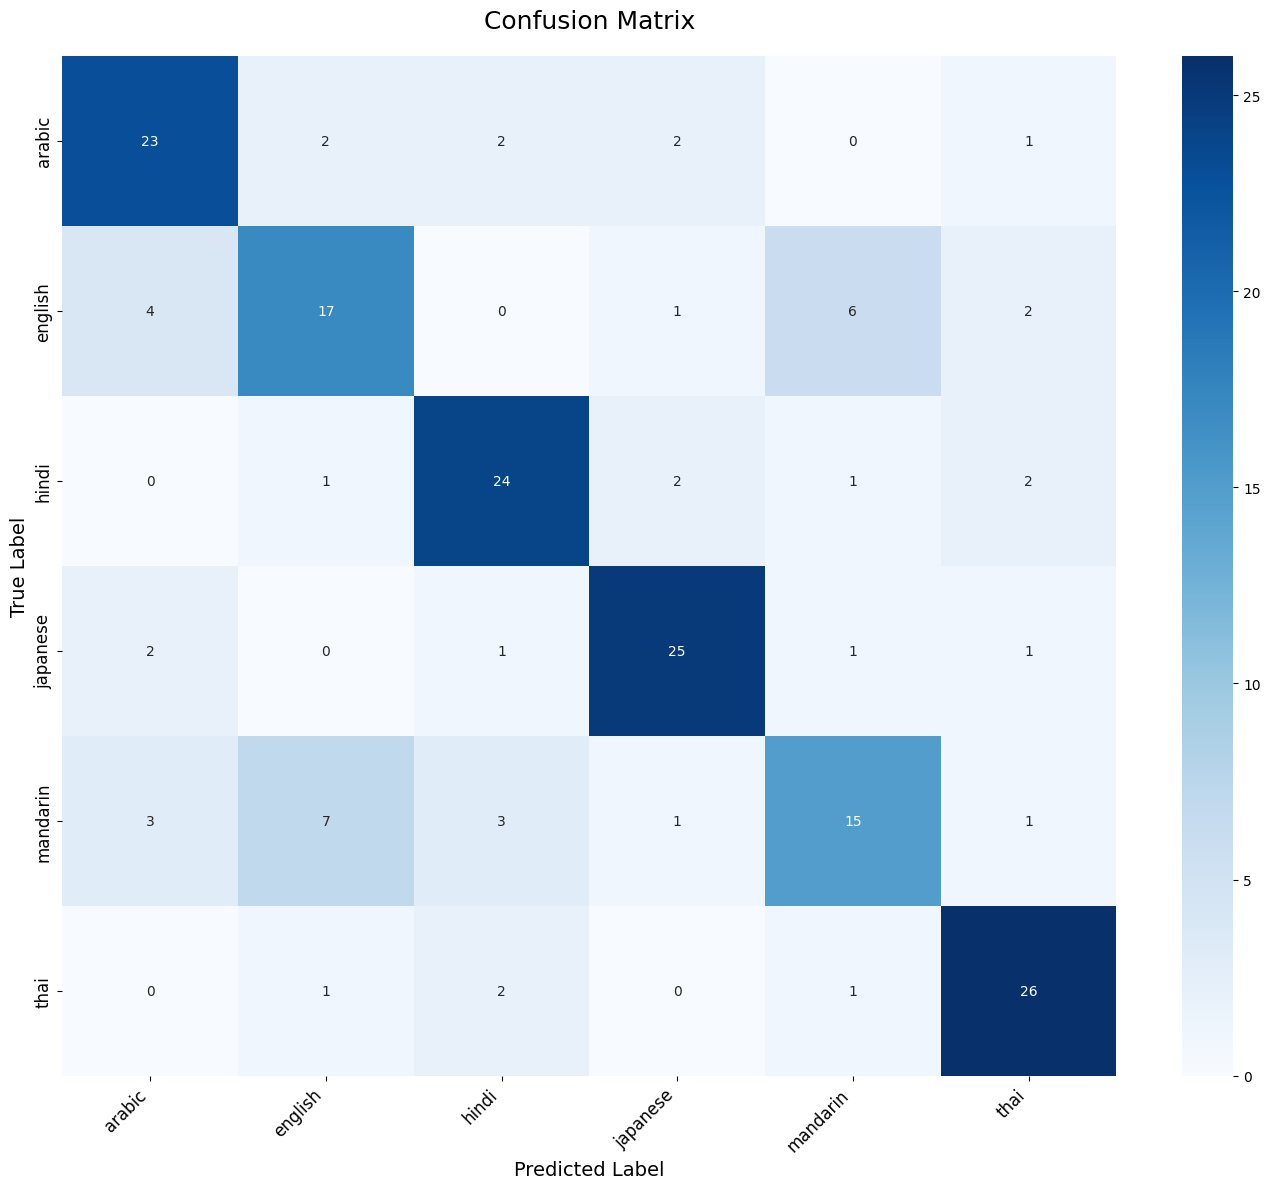

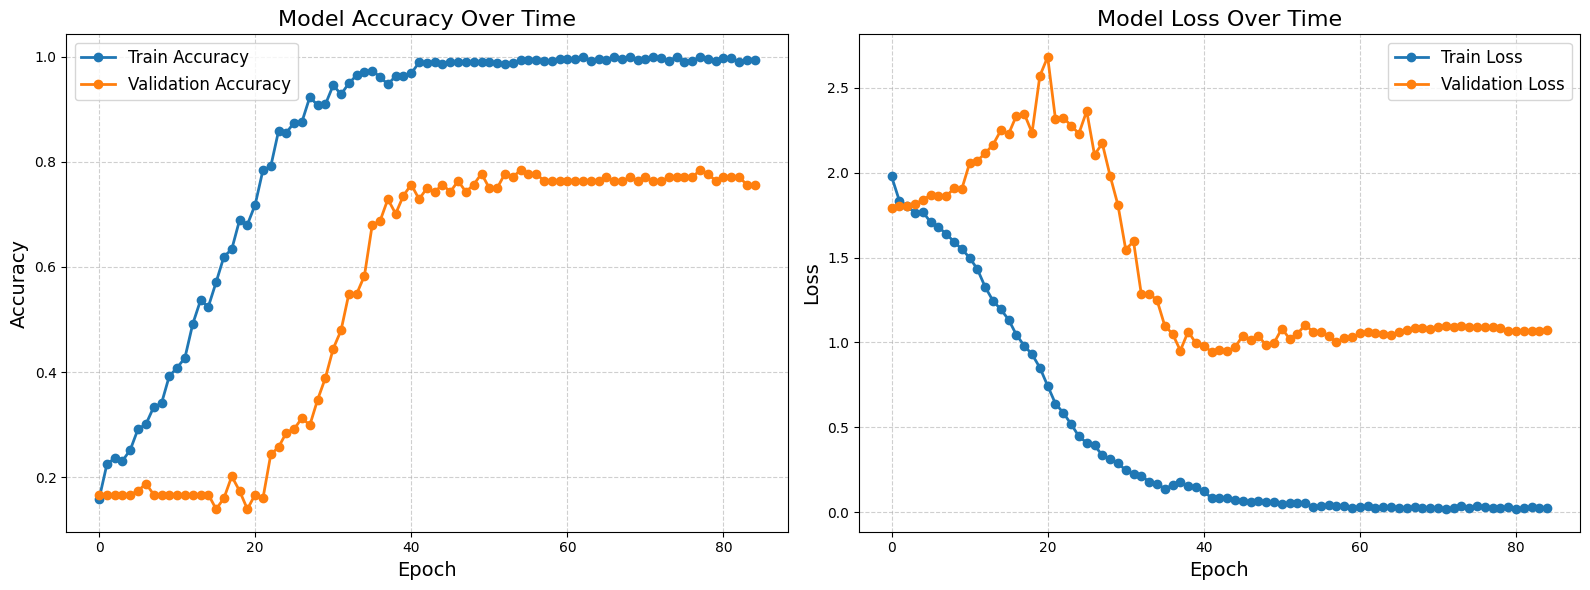

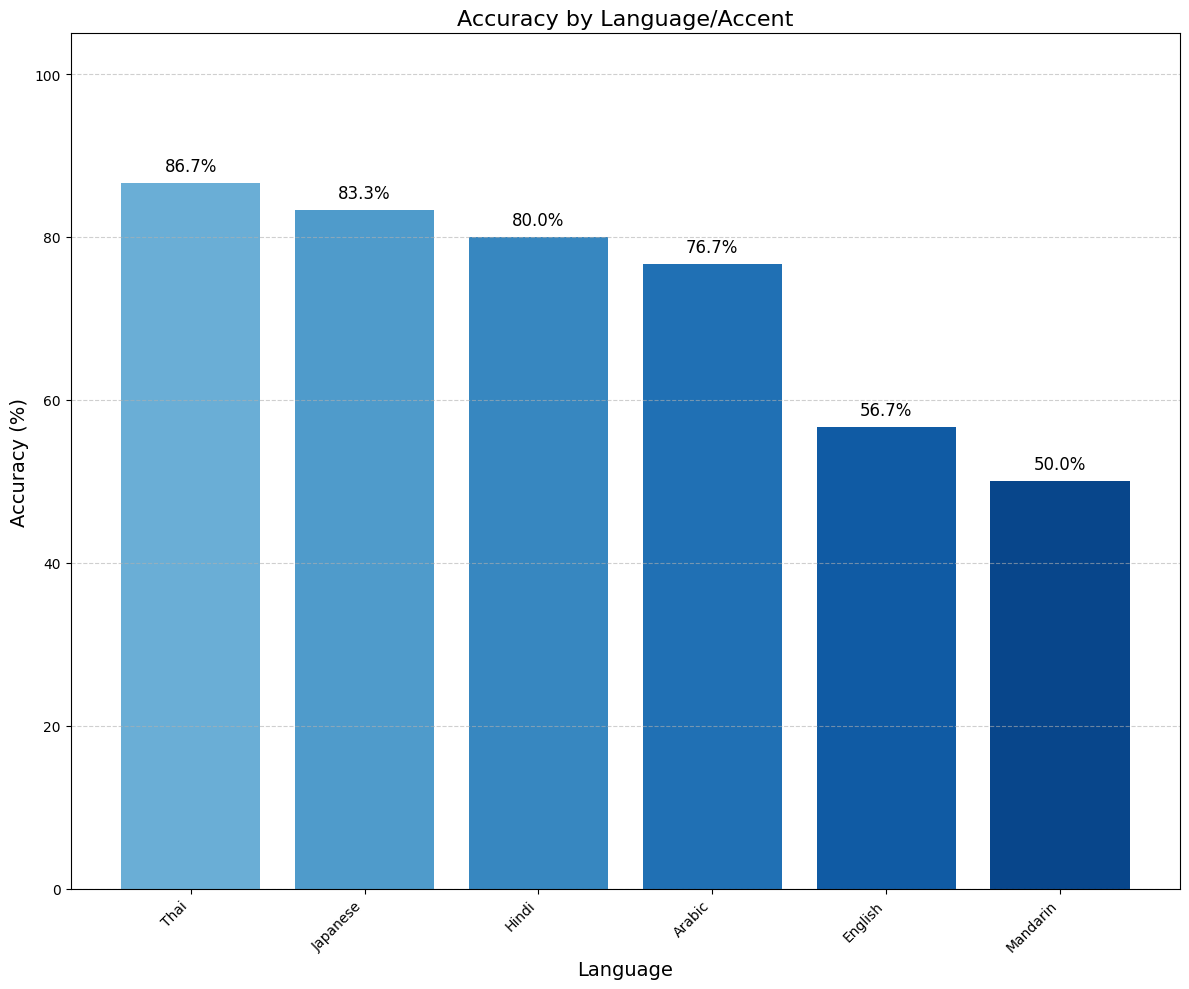


===== ตัวอย่างการทำนาย =====

ตัวอย่างที่ 1:
สำเนียงจริง: thai
อันดับ 1: thai - 100.0%
อันดับ 2: japanese - 0.0%
อันดับ 3: arabic - 0.0%

ตัวอย่างที่ 2:
สำเนียงจริง: mandarin
อันดับ 1: mandarin - 99.8%
อันดับ 2: hindi - 0.1%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 3:
สำเนียงจริง: english
อันดับ 1: english - 99.9%
อันดับ 2: thai - 0.0%
อันดับ 3: arabic - 0.0%

ตัวอย่างที่ 4:
สำเนียงจริง: hindi
อันดับ 1: japanese - 75.3%
อันดับ 2: english - 22.2%
อันดับ 3: thai - 1.7%

ตัวอย่างที่ 5:
สำเนียงจริง: japanese
อันดับ 1: japanese - 100.0%
อันดับ 2: thai - 0.0%
อันดับ 3: english - 0.0%

===== กำลังฝึกสอนโมเดล ResNet =====
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1741 - loss: 1.9737
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.1746 - loss: 1.9703 - val_accuracy: 0.1667 - val_loss: 1.7967 - learning_rate: 3.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2158 - loss: 1.7959
Epoch 2: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.2175 - loss: 1.7954 - val_accuracy: 0.1667 - val_loss: 1.8153 - learning_rate: 3.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2757 - loss: 1.7179
Epoch 3: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2763 - loss: 1.7167 - val_accuracy: 0.1667 - val_loss: 1.8522 - learning_rate: 3.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3265 - loss: 1.6141
Epoch 4: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.3269 - loss: 1.6139 - val_accuracy: 0.1667 - val_loss: 1.8906 - learning_rate: 3.0000e-04
Epoch 5/

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9842 - loss: 0.1231 - val_accuracy: 0.1736 - val_loss: 3.7292 - learning_rate: 1.5000e-04
Epoch 15/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9834 - loss: 0.1149
Epoch 15: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9836 - loss: 0.1141 - val_accuracy: 0.1597 - val_loss: 3.8943 - learning_rate: 1.5000e-04
Epoch 16/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9856 - loss: 0.0775
Epoch 16: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9855 - loss: 0.0777 - val_accuracy: 0.1319 - val_loss: 3.5365 - learning_rate: 1.5000e-04
Epoch 17/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9902 - loss: 0.0848
Epoch 17: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9904 - loss: 0.0836 - val_accuracy: 0.1528 - val_loss: 4.0882 - learning_rate: 1.5000e-04


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9996 - loss: 0.0172 - val_accuracy: 0.2153 - val_loss: 2.9571 - learning_rate: 7.5000e-05
Epoch 27/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9976 - loss: 0.0145
Epoch 27: val_accuracy improved from 0.21528 to 0.26389, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9976 - loss: 0.0146 - val_accuracy: 0.2639 - val_loss: 2.8729 - learning_rate: 7.5000e-05
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9998 - loss: 0.0175
Epoch 28: val_accuracy improved from 0.26389 to 0.27778, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9997 - loss: 0.0175 - val_accuracy: 0.2778 - val_loss: 3.5677 - learning_rate: 7.5000e-05
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9990 - loss: 0.0130
Epoch 29: val_accuracy improved from 0.27778 to 0.31250, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9990 - loss: 0.0132 - val_accuracy: 0.3125 - val_loss: 3.2171 - learning_rate: 7.5000e-05
Epoch 30/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0192
Epoch 30: val_accuracy improved from 0.31250 to 0.34028, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.3403 - val_loss: 2.6366 - learning_rate: 7.5000e-05
Epoch 31/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9996 - loss: 0.0154
Epoch 31: val_accuracy improved from 0.34028 to 0.35417, saving model to Model\accent_resnet_model.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9995 - loss: 0.0155 - val_accuracy: 0.3542 - val_loss: 2.5932 - learning_rate: 3.7500e-05
Epoch 32/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0113
Epoch 32: val_accuracy improved from 0.35417 to 0.41667, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.4167 - val_loss: 2.2489 - learning_rate: 3.7500e-05
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9957 - loss: 0.0243
Epoch 33: val_accuracy improved from 0.41667 to 0.47917, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9958 - loss: 0.0239 - val_accuracy: 0.4792 - val_loss: 1.7855 - learning_rate: 3.7500e-05
Epoch 34/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0121
Epoch 34: val_accuracy improved from 0.47917 to 0.56944, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.5694 - val_loss: 1.3629 - learning_rate: 3.7500e-05
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0105
Epoch 35: val_accuracy improved from 0.56944 to 0.66667, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.6667 - val_loss: 1.0684 - learning_rate: 3.7500e-05
Epoch 36/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9993 - loss: 0.0113
Epoch 36: val_accuracy improved from 0.66667 to 0.72222, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9993 - loss: 0.0114 - val_accuracy: 0.7222 - val_loss: 0.8553 - learning_rate: 3.7500e-05
Epoch 37/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0119
Epoch 37: val_accuracy improved from 0.72222 to 0.79167, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.7917 - val_loss: 0.6548 - learning_rate: 3.7500e-05
Epoch 38/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0110
Epoch 38: val_accuracy improved from 0.79167 to 0.83333, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.8333 - val_loss: 0.5091 - learning_rate: 3.7500e-05
Epoch 39/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0101
Epoch 39: val_accuracy did not improve from 0.83333
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.8056 - val_loss: 0.5342 - learning_rate: 3.7500e-05
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9982 - loss: 0.0141
Epoch 40: val_accuracy improved from 0.83333 to 0.84722, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9982 - loss: 0.0141 - val_accuracy: 0.8472 - val_loss: 0.5255 - learning_rate: 3.7500e-05
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9992 - loss: 0.0177
Epoch 41: val_accuracy did not improve from 0.84722
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9991 - loss: 0.0177 - val_accuracy: 0.8264 - val_loss: 0.5681 - learning_rate: 3.7500e-05
Epoch 42/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0079
Epoch 42: val_accuracy improved from 0.84722 to 0.86111, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.8611 - val_loss: 0.4394 - learning_rate: 3.7500e-05
Epoch 43/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0090
Epoch 43: val_accuracy did not improve from 0.86111
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.8542 - val_loss: 0.4197 - learning_rate: 3.7500e-05
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 44: val_accuracy improved from 0.86111 to 0.87500, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8750 - val_loss: 0.4292 - learning_rate: 3.7500e-05
Epoch 45/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0086
Epoch 45: val_accuracy did not improve from 0.87500
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.8750 - val_loss: 0.3988 - learning_rate: 3.7500e-05
Epoch 46/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 0.0084
Epoch 46: val_accuracy improved from 0.87500 to 0.88889, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8889 - val_loss: 0.3881 - learning_rate: 3.7500e-05
Epoch 47/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0079
Epoch 47: val_accuracy did not improve from 0.88889
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.8750 - val_loss: 0.4005 - learning_rate: 3.7500e-05
Epoch 48/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9975 - loss: 0.0103
Epoch 48: val_accuracy did not improve from 0.88889
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9976 - loss: 0.0102 - val_accuracy: 0.8542 - val_loss: 0.4789 - learning_rate: 3.7500e-05
Epoch 49/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9963 - loss: 0.0156
Epoch 49: val_accuracy did not improve from 0.88889
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9963 - loss: 0.0155 - val_accuracy: 0.8542 - val_loss: 0.5511 - learning_rate: 3.7500e-05



===== ผลลัพธ์การทดสอบโมเดล ResNet =====
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8408 - loss: 0.6495

ความแม่นยำบนชุดข้อมูลทดสอบ: 83.33%
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step

===== รายงานประสิทธิภาพโมเดล =====
Accuracy: 83.33%
Precision: 83.53%
Recall: 83.33%
F1 Score: 83.17%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       1.00      0.87      0.93        30
     english       0.71      0.73      0.72        30
       hindi       0.88      0.97      0.92        30
    japanese       0.93      0.90      0.92        30
    mandarin       0.69      0.60      0.64        30
        thai       0.80      0.93      0.86        30

    accuracy                           0.83       180
   macro avg       0.84      0.83      0.83       180
weighted avg       0.84      0.83      0.83       180



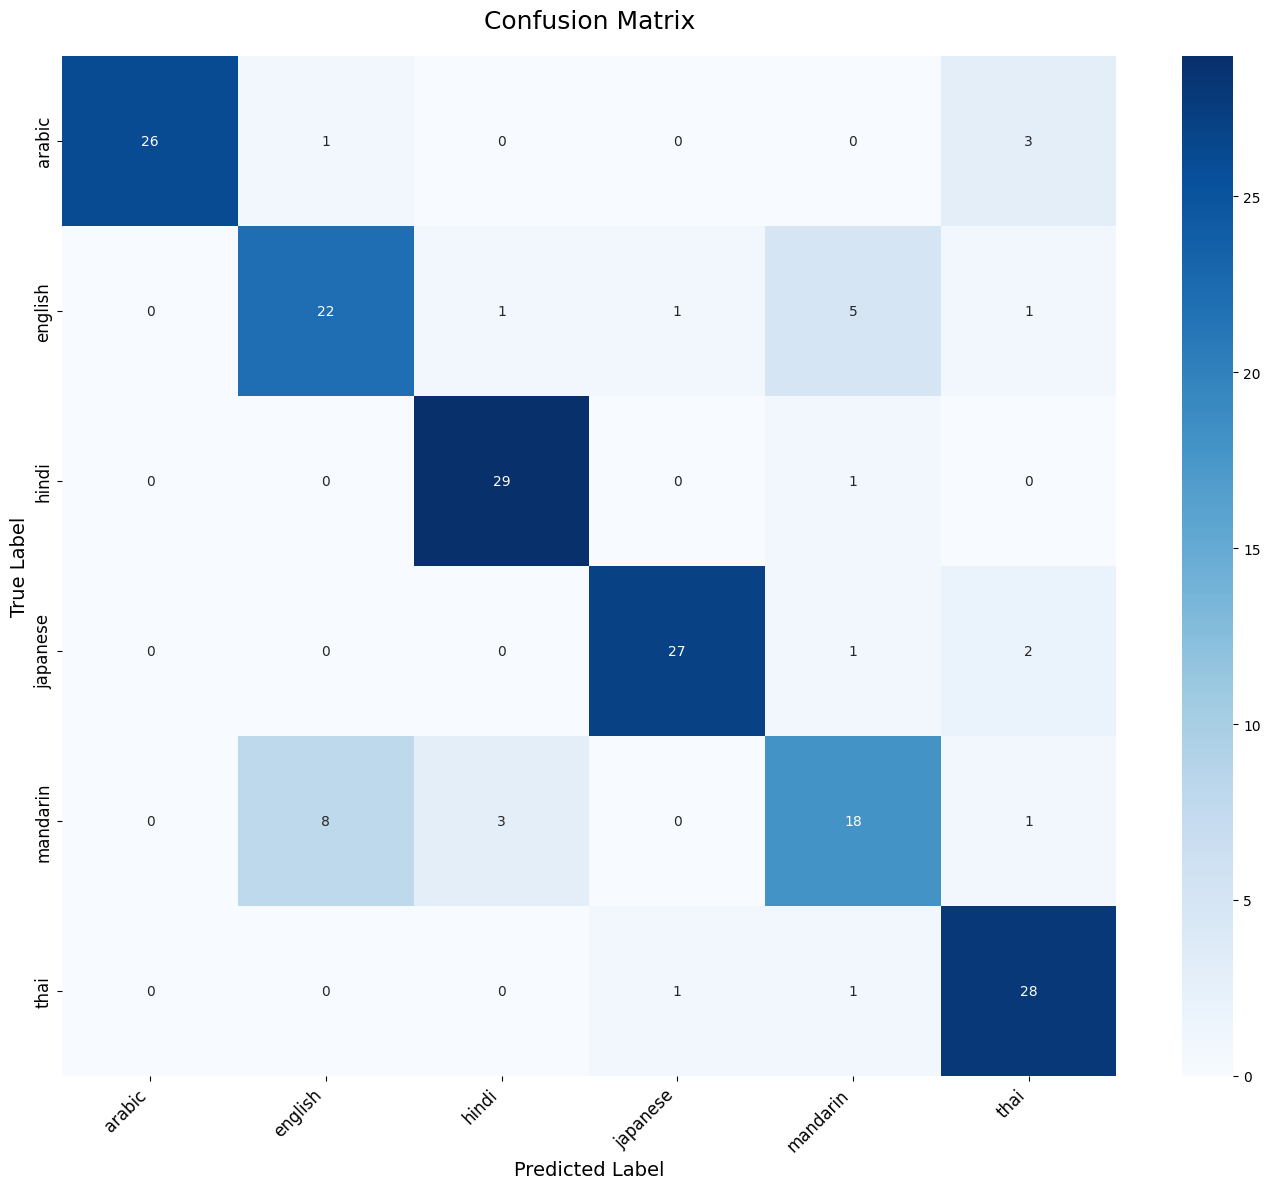

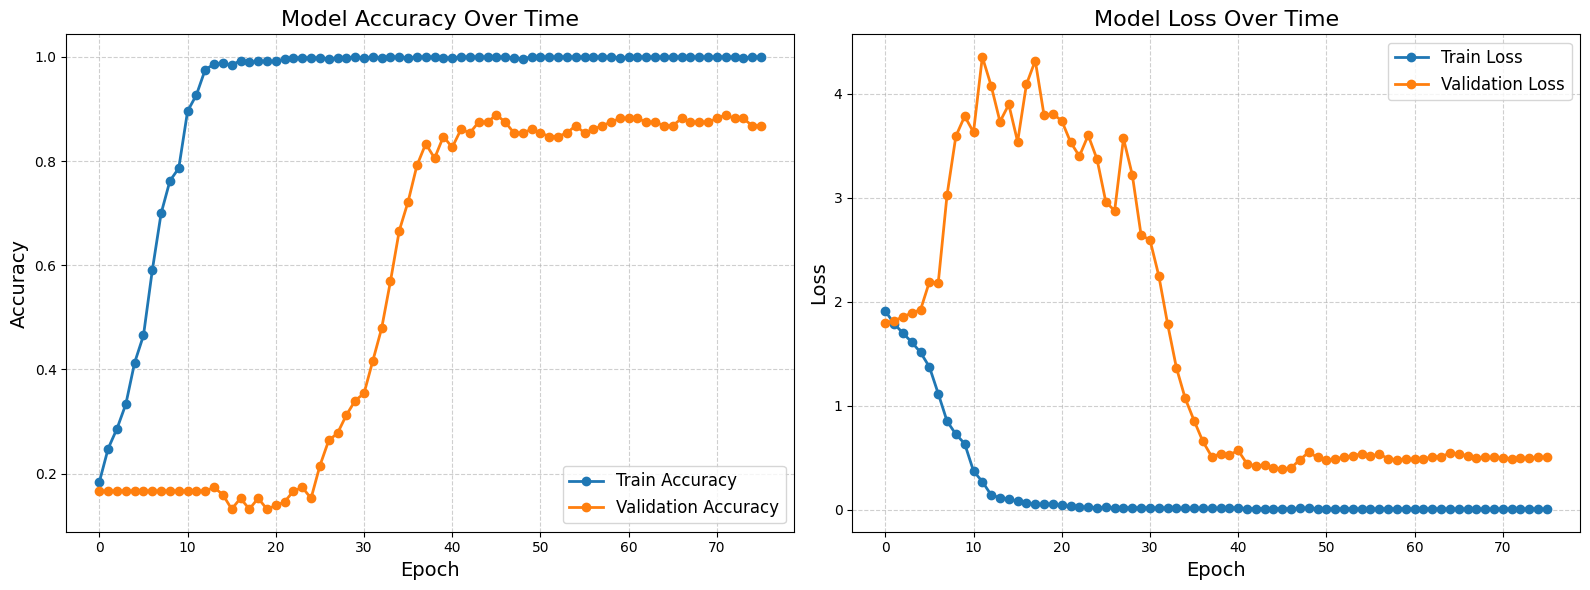

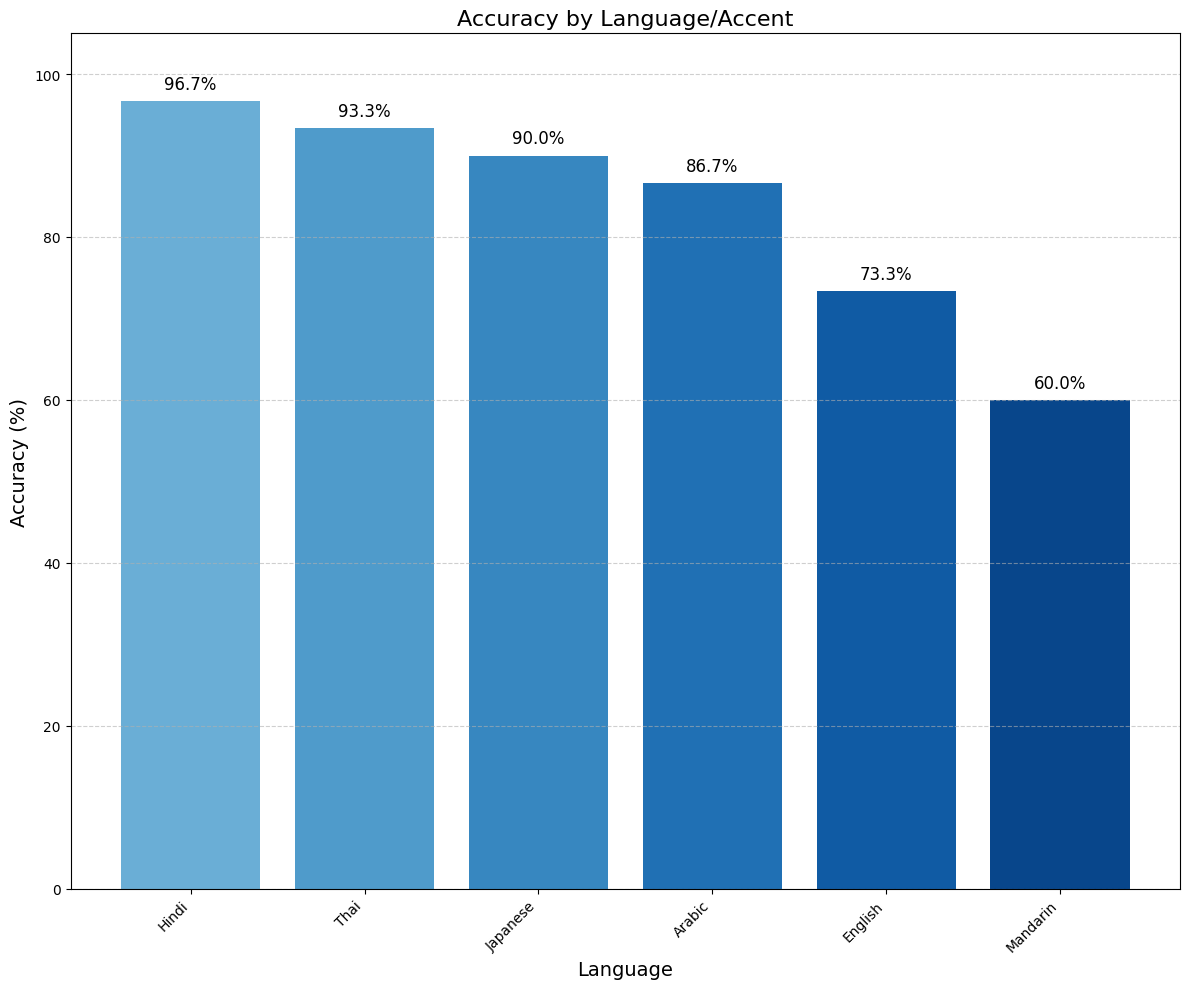


===== ตัวอย่างการทำนาย =====

ตัวอย่างที่ 1:
สำเนียงจริง: hindi
อันดับ 1: hindi - 99.9%
อันดับ 2: mandarin - 0.0%
อันดับ 3: arabic - 0.0%

ตัวอย่างที่ 2:
สำเนียงจริง: english
อันดับ 1: english - 98.3%
อันดับ 2: mandarin - 1.6%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 3:
สำเนียงจริง: arabic
อันดับ 1: thai - 59.7%
อันดับ 2: mandarin - 40.3%
อันดับ 3: english - 0.0%

ตัวอย่างที่ 4:
สำเนียงจริง: japanese
อันดับ 1: japanese - 100.0%
อันดับ 2: english - 0.0%
อันดับ 3: arabic - 0.0%

ตัวอย่างที่ 5:
สำเนียงจริง: mandarin
อันดับ 1: mandarin - 90.0%
อันดับ 2: hindi - 8.3%
อันดับ 3: thai - 1.4%

===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====
กำลังสร้างโมเดลที่ 1/2...
กำลังสร้างโมเดลที่ 2/2...
กำลังฝึกสอนโมเดลที่ 1/2...
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1897 - loss: 1.9856
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 445ms/step - accuracy: 0.1899 - loss: 1.9849 - val_accuracy: 0.1667 - val_loss: 1.7975 - learning_rate: 3.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.2013 - loss: 1.9155
Epoch 2: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.2015 - loss: 1.9143 - val_accuracy: 0.1667 - val_loss: 1.8163 - learning_rate: 3.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2607 - loss: 1.7979
Epoch 3: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - accuracy: 0.2598 - loss: 1.7983 - val_accuracy: 0.1667 - val_loss: 1.8305 - learning_rate: 3.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.1991 - loss: 1.8256
Epoch 4: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 579ms/step - accuracy: 0.1999 - loss: 1.8247 - val_accuracy: 0.1667 - val_loss: 1.8652 - learning_rate: 3.0000e-04
Epo

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.3170 - loss: 1.6542 - val_accuracy: 0.1875 - val_loss: 1.9081 - learning_rate: 3.0000e-04
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.3166 - loss: 1.6566
Epoch 8: val_accuracy improved from 0.18750 to 0.21528, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.3165 - loss: 1.6561 - val_accuracy: 0.2153 - val_loss: 1.9236 - learning_rate: 3.0000e-04
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.3319 - loss: 1.6155
Epoch 9: val_accuracy did not improve from 0.21528
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step - accuracy: 0.3329 - loss: 1.6128 - val_accuracy: 0.1667 - val_loss: 1.9827 - learning_rate: 3.0000e-04
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.4018 - loss: 1.5107
Epoch 10: val_accuracy did not improve from 0.21528
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 505ms/step - accuracy: 0.4013 - loss: 1.5108 - val_accuracy: 0.1667 - val_loss: 1.9750 - learning_rate: 3.0000e-04
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.3700 - loss: 1.5028
Epoch 11: val_accuracy improved from 0.21528 to 0.23611, saving model to Model\accent_ensemble_model_1.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 520ms/step - accuracy: 0.3707 - loss: 1.5017 - val_accuracy: 0.2361 - val_loss: 2.0414 - learning_rate: 1.5000e-04
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4506 - loss: 1.3651
Epoch 12: val_accuracy did not improve from 0.23611
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.4522 - loss: 1.3626 - val_accuracy: 0.1667 - val_loss: 2.0605 - learning_rate: 1.5000e-04
Epoch 13/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5000 - loss: 1.2274
Epoch 13: val_accuracy did not improve from 0.23611
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - accuracy: 0.4992 - loss: 1.2282 - val_accuracy: 0.2153 - val_loss: 2.1326 - learning_rate: 1.5000e-04
Epoch 14/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.5024 - loss: 1.2722
Epoch 14: val_accuracy did not improve from 0.23611
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - accuracy: 0.5047 - loss:

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.8870 - loss: 0.3944 - val_accuracy: 0.2431 - val_loss: 2.8263 - learning_rate: 7.5000e-05
Epoch 27/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9051 - loss: 0.3439
Epoch 27: val_accuracy improved from 0.24306 to 0.31944, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 515ms/step - accuracy: 0.9037 - loss: 0.3457 - val_accuracy: 0.3194 - val_loss: 2.4867 - learning_rate: 7.5000e-05
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8590 - loss: 0.3558
Epoch 28: val_accuracy did not improve from 0.31944
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 0.8602 - loss: 0.3557 - val_accuracy: 0.2569 - val_loss: 2.8115 - learning_rate: 7.5000e-05
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9108 - loss: 0.3409
Epoch 29: val_accuracy did not improve from 0.31944
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.9106 - loss: 0.3407 - val_accuracy: 0.3194 - val_loss: 2.5549 - learning_rate: 7.5000e-05
Epoch 30/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9015 - loss: 0.3021
Epoch 30: val_accuracy improved from 0.31944 to 0.32639, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 519ms/step - accuracy: 0.9017 - loss: 0.3020 - val_accuracy: 0.3264 - val_loss: 2.6369 - learning_rate: 7.5000e-05
Epoch 31/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9120 - loss: 0.2867
Epoch 31: val_accuracy improved from 0.32639 to 0.38889, saving model to Model\accent_ensemble_model_1.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.9125 - loss: 0.2864 - val_accuracy: 0.3889 - val_loss: 2.2259 - learning_rate: 3.7500e-05
Epoch 32/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9077 - loss: 0.2784
Epoch 32: val_accuracy did not improve from 0.38889
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.9075 - loss: 0.2791 - val_accuracy: 0.3472 - val_loss: 2.2105 - learning_rate: 3.7500e-05
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9321 - loss: 0.2505
Epoch 33: val_accuracy improved from 0.38889 to 0.43056, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.9320 - loss: 0.2509 - val_accuracy: 0.4306 - val_loss: 1.8797 - learning_rate: 3.7500e-05
Epoch 34/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9392 - loss: 0.2265
Epoch 34: val_accuracy improved from 0.43056 to 0.49306, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step - accuracy: 0.9389 - loss: 0.2266 - val_accuracy: 0.4931 - val_loss: 1.6160 - learning_rate: 3.7500e-05
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9172 - loss: 0.2332
Epoch 35: val_accuracy improved from 0.49306 to 0.55556, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 520ms/step - accuracy: 0.9181 - loss: 0.2329 - val_accuracy: 0.5556 - val_loss: 1.3724 - learning_rate: 3.7500e-05
Epoch 36/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9723 - loss: 0.1840
Epoch 36: val_accuracy improved from 0.55556 to 0.58333, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 534ms/step - accuracy: 0.9723 - loss: 0.1838 - val_accuracy: 0.5833 - val_loss: 1.2982 - learning_rate: 3.7500e-05
Epoch 37/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9699 - loss: 0.1738
Epoch 37: val_accuracy improved from 0.58333 to 0.63194, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - accuracy: 0.9696 - loss: 0.1742 - val_accuracy: 0.6319 - val_loss: 1.2106 - learning_rate: 3.7500e-05
Epoch 38/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9247 - loss: 0.2220
Epoch 38: val_accuracy improved from 0.63194 to 0.68056, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 506ms/step - accuracy: 0.9253 - loss: 0.2206 - val_accuracy: 0.6806 - val_loss: 1.0277 - learning_rate: 3.7500e-05
Epoch 39/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9730 - loss: 0.1609
Epoch 39: val_accuracy improved from 0.68056 to 0.70833, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.9728 - loss: 0.1613 - val_accuracy: 0.7083 - val_loss: 0.9806 - learning_rate: 3.7500e-05
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9620 - loss: 0.1616
Epoch 40: val_accuracy improved from 0.70833 to 0.72917, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.9619 - loss: 0.1619 - val_accuracy: 0.7292 - val_loss: 0.8998 - learning_rate: 3.7500e-05
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9713 - loss: 0.1569
Epoch 41: val_accuracy improved from 0.72917 to 0.75000, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step - accuracy: 0.9712 - loss: 0.1567 - val_accuracy: 0.7500 - val_loss: 0.8391 - learning_rate: 3.7500e-05
Epoch 42/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9693 - loss: 0.1436
Epoch 42: val_accuracy improved from 0.75000 to 0.75694, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step - accuracy: 0.9693 - loss: 0.1438 - val_accuracy: 0.7569 - val_loss: 0.8317 - learning_rate: 3.7500e-05
Epoch 43/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9660 - loss: 0.1587
Epoch 43: val_accuracy improved from 0.75694 to 0.76389, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - accuracy: 0.9660 - loss: 0.1580 - val_accuracy: 0.7639 - val_loss: 0.8348 - learning_rate: 3.7500e-05
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9514 - loss: 0.1776
Epoch 44: val_accuracy did not improve from 0.76389
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.9516 - loss: 0.1770 - val_accuracy: 0.7639 - val_loss: 0.8539 - learning_rate: 3.7500e-05
Epoch 45/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9720 - loss: 0.1333
Epoch 45: val_accuracy did not improve from 0.76389
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9720 - loss: 0.1336 - val_accuracy: 0.7639 - val_loss: 0.8211 - learning_rate: 3.7500e-05
Epoch 46/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9731 - loss: 0.1340
Epoch 46: val_accuracy improved from 0.76389 to 0.78472, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 534ms/step - accuracy: 0.9732 - loss: 0.1335 - val_accuracy: 0.7847 - val_loss: 0.8295 - learning_rate: 3.7500e-05
Epoch 47/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9662 - loss: 0.1384
Epoch 47: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - accuracy: 0.9666 - loss: 0.1379 - val_accuracy: 0.7569 - val_loss: 0.8588 - learning_rate: 3.7500e-05
Epoch 48/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9676 - loss: 0.1225
Epoch 48: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.9676 - loss: 0.1224 - val_accuracy: 0.7639 - val_loss: 0.8313 - learning_rate: 3.7500e-05
Epoch 49/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9841 - loss: 0.0981
Epoch 49: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - accuracy: 0.9839 - loss: 0.0986 - val_accuracy: 0.7500 - val_loss: 0.8450 - learning_rate: 3.7500e-05


Epoch 55: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 515ms/step - accuracy: 0.9872 - loss: 0.0720 - val_accuracy: 0.7986 - val_loss: 0.8694 - learning_rate: 1.8750e-05
Epoch 56/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9966 - loss: 0.0605
Epoch 56: val_accuracy did not improve from 0.79861
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - accuracy: 0.9965 - loss: 0.0608 - val_accuracy: 0.7778 - val_loss: 0.8894 - learning_rate: 1.8750e-05
Epoch 57/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9937 - loss: 0.0712
Epoch 57: val_accuracy improved from 0.79861 to 0.80556, saving model to Model\accent_ensemble_model_1.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.9935 - loss: 0.0713 - val_accuracy: 0.8056 - val_loss: 0.8697 - learning_rate: 1.8750e-05
Epoch 58/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9915 - loss: 0.0758
Epoch 58: val_accuracy did not improve from 0.80556
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.9912 - loss: 0.0763 - val_accuracy: 0.7847 - val_loss: 0.8625 - learning_rate: 1.8750e-05
Epoch 59/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9865 - loss: 0.0777
Epoch 59: val_accuracy did not improve from 0.80556
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 482ms/step - accuracy: 0.9864 - loss: 0.0778 - val_accuracy: 0.7917 - val_loss: 0.8497 - learning_rate: 1.8750e-05
Epoch 60/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9769 - loss: 0.0908
Epoch 60: val_accuracy did not improve from 0.80556
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.9771 - loss: 0.0904 - val_accuracy: 0.7986 - val_loss: 0.8375 - learning_rate: 1.8750e-05


กำลังฝึกสอนโมเดลที่ 2/2...
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1981 - loss: 2.0235
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.1982 - loss: 2.0172 - val_accuracy: 0.1667 - val_loss: 1.7933 - learning_rate: 3.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1946 - loss: 1.7971
Epoch 2: val_accuracy improved from 0.16667 to 0.17361, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.1958 - loss: 1.7973 - val_accuracy: 0.1736 - val_loss: 1.7960 - learning_rate: 3.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2753 - loss: 1.7182
Epoch 3: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.2743 - loss: 1.7186 - val_accuracy: 0.1667 - val_loss: 1.8042 - learning_rate: 3.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2944 - loss: 1.6633
Epoch 4: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.2952 - loss: 1.6621 - val_accuracy: 0.1528 - val_loss: 1.8377 - learning_rate: 3.0000e-04
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3699 - loss: 1.5867
Epoch 5: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3701 - loss: 1.5850 - val_accuracy: 0.1667 - val_loss: 1.8990 - learning_rate: 3.0000e-04
Epoch 6/2

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9645 - loss: 0.1536 - val_accuracy: 0.1944 - val_loss: 2.5951 - learning_rate: 1.5000e-04
Epoch 16/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9706 - loss: 0.1257
Epoch 16: val_accuracy did not improve from 0.19444
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9711 - loss: 0.1249 - val_accuracy: 0.1944 - val_loss: 2.6251 - learning_rate: 1.5000e-04
Epoch 17/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9801 - loss: 0.0925
Epoch 17: val_accuracy did not improve from 0.19444
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9802 - loss: 0.0928 - val_accuracy: 0.1806 - val_loss: 2.5122 - learning_rate: 1.5000e-04
Epoch 18/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9833 - loss: 0.0753
Epoch 18: val_accuracy did not improve from 0.19444
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9835 - loss: 0.0750 - val_accuracy: 0.1736 - val_loss: 2.8522 - learning_rate: 1.5000e-04


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9891 - loss: 0.0557 - val_accuracy: 0.2153 - val_loss: 4.4726 - learning_rate: 7.5000e-05
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9954 - loss: 0.0295
Epoch 28: val_accuracy did not improve from 0.21528
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9955 - loss: 0.0293 - val_accuracy: 0.1875 - val_loss: 4.7341 - learning_rate: 7.5000e-05
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9975 - loss: 0.0254
Epoch 29: val_accuracy did not improve from 0.21528
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9975 - loss: 0.0255 - val_accuracy: 0.1875 - val_loss: 4.5055 - learning_rate: 7.5000e-05
Epoch 30/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.0207
Epoch 30: val_accuracy improved from 0.21528 to 0.27778, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 0.0207 - val_accuracy: 0.2778 - val_loss: 3.4252 - learning_rate: 7.5000e-05
Epoch 31/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9967 - loss: 0.0307
Epoch 31: val_accuracy improved from 0.27778 to 0.38194, saving model to Model\accent_ensemble_model_2.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9967 - loss: 0.0302 - val_accuracy: 0.3819 - val_loss: 2.8017 - learning_rate: 3.7500e-05
Epoch 32/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0159
Epoch 32: val_accuracy improved from 0.38194 to 0.40278, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.4028 - val_loss: 2.6107 - learning_rate: 3.7500e-05
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0115
Epoch 33: val_accuracy improved from 0.40278 to 0.41667, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.4167 - val_loss: 2.5197 - learning_rate: 3.7500e-05
Epoch 34/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0185
Epoch 34: val_accuracy improved from 0.41667 to 0.50000, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.5000 - val_loss: 1.8626 - learning_rate: 3.7500e-05
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0184
Epoch 35: val_accuracy did not improve from 0.50000
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.5000 - val_loss: 1.8500 - learning_rate: 3.7500e-05
Epoch 36/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0123
Epoch 36: val_accuracy improved from 0.50000 to 0.60417, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 0.6042 - val_loss: 1.3064 - learning_rate: 3.7500e-05
Epoch 37/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0133
Epoch 37: val_accuracy improved from 0.60417 to 0.72917, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.7292 - val_loss: 0.8271 - learning_rate: 3.7500e-05
Epoch 38/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9982 - loss: 0.0122
Epoch 38: val_accuracy improved from 0.72917 to 0.79861, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9982 - loss: 0.0122 - val_accuracy: 0.7986 - val_loss: 0.6034 - learning_rate: 3.7500e-05
Epoch 39/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0184
Epoch 39: val_accuracy improved from 0.79861 to 0.86806, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.8681 - val_loss: 0.4232 - learning_rate: 3.7500e-05
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9982 - loss: 0.0146
Epoch 40: val_accuracy improved from 0.86806 to 0.88889, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9982 - loss: 0.0146 - val_accuracy: 0.8889 - val_loss: 0.3397 - learning_rate: 3.7500e-05
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9965 - loss: 0.0137
Epoch 41: val_accuracy improved from 0.88889 to 0.91667, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9966 - loss: 0.0137 - val_accuracy: 0.9167 - val_loss: 0.2981 - learning_rate: 3.7500e-05
Epoch 42/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0081
Epoch 42: val_accuracy did not improve from 0.91667
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.8889 - val_loss: 0.3472 - learning_rate: 3.7500e-05
Epoch 43/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9982 - loss: 0.0118
Epoch 43: val_accuracy did not improve from 0.91667
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9982 - loss: 0.0118 - val_accuracy: 0.6944 - val_loss: 0.9956 - learning_rate: 3.7500e-05
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9971 - loss: 0.0207
Epoch 44: val_accuracy did not improve from 0.91667
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9971 - loss: 0.0208 - val_accuracy: 0.8333 - val_loss: 0.5097 - learning_rate: 3.7500e-05


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9998 - loss: 0.0134 - val_accuracy: 0.9236 - val_loss: 0.2364 - learning_rate: 3.7500e-05
Epoch 53/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9960 - loss: 0.0127
Epoch 53: val_accuracy did not improve from 0.92361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9959 - loss: 0.0128 - val_accuracy: 0.9097 - val_loss: 0.2315 - learning_rate: 3.7500e-05
Epoch 54/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0100
Epoch 54: val_accuracy did not improve from 0.92361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9097 - val_loss: 0.2201 - learning_rate: 3.7500e-05
Epoch 55/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0058
Epoch 55: val_accuracy improved from 0.92361 to 0.93056, saving model to Model\accent_ensemble_model_2.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9306 - val_loss: 0.2199 - learning_rate: 3.7500e-05
Epoch 56/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9996 - loss: 0.0066
Epoch 56: val_accuracy did not improve from 0.93056
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9995 - loss: 0.0067 - val_accuracy: 0.9306 - val_loss: 0.2137 - learning_rate: 3.7500e-05
Epoch 57/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9993 - loss: 0.0059
Epoch 57: val_accuracy did not improve from 0.93056
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9990 - loss: 0.0064 - val_accuracy: 0.8750 - val_loss: 0.2929 - learning_rate: 3.7500e-05
Epoch 58/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9984 - loss: 0.0114
Epoch 58: val_accuracy did not improve from 0.93056
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9984 - loss: 0.0114 - val_accuracy: 0.7083 - val_loss: 0.8981 - learning_rate: 3.7500e-05



===== ผลลัพธ์การทดสอบโมเดล Ensemble =====


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step

===== รายงานประสิทธิภาพโมเดล Ensemble =====
Accuracy: 80.56%
Precision: 80.62%
Recall: 80.56%
F1 Score: 80.31%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       0.84      0.87      0.85        30
     english       0.69      0.83      0.76        30
       hindi       0.83      0.80      0.81        30
    japanese       0.89      0.83      0.86        30
    mandarin       0.71      0.57      0.63        30
        thai       0.88      0.93      0.90        30

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.80       180
weighted avg       0.81      0.81      0.80       180



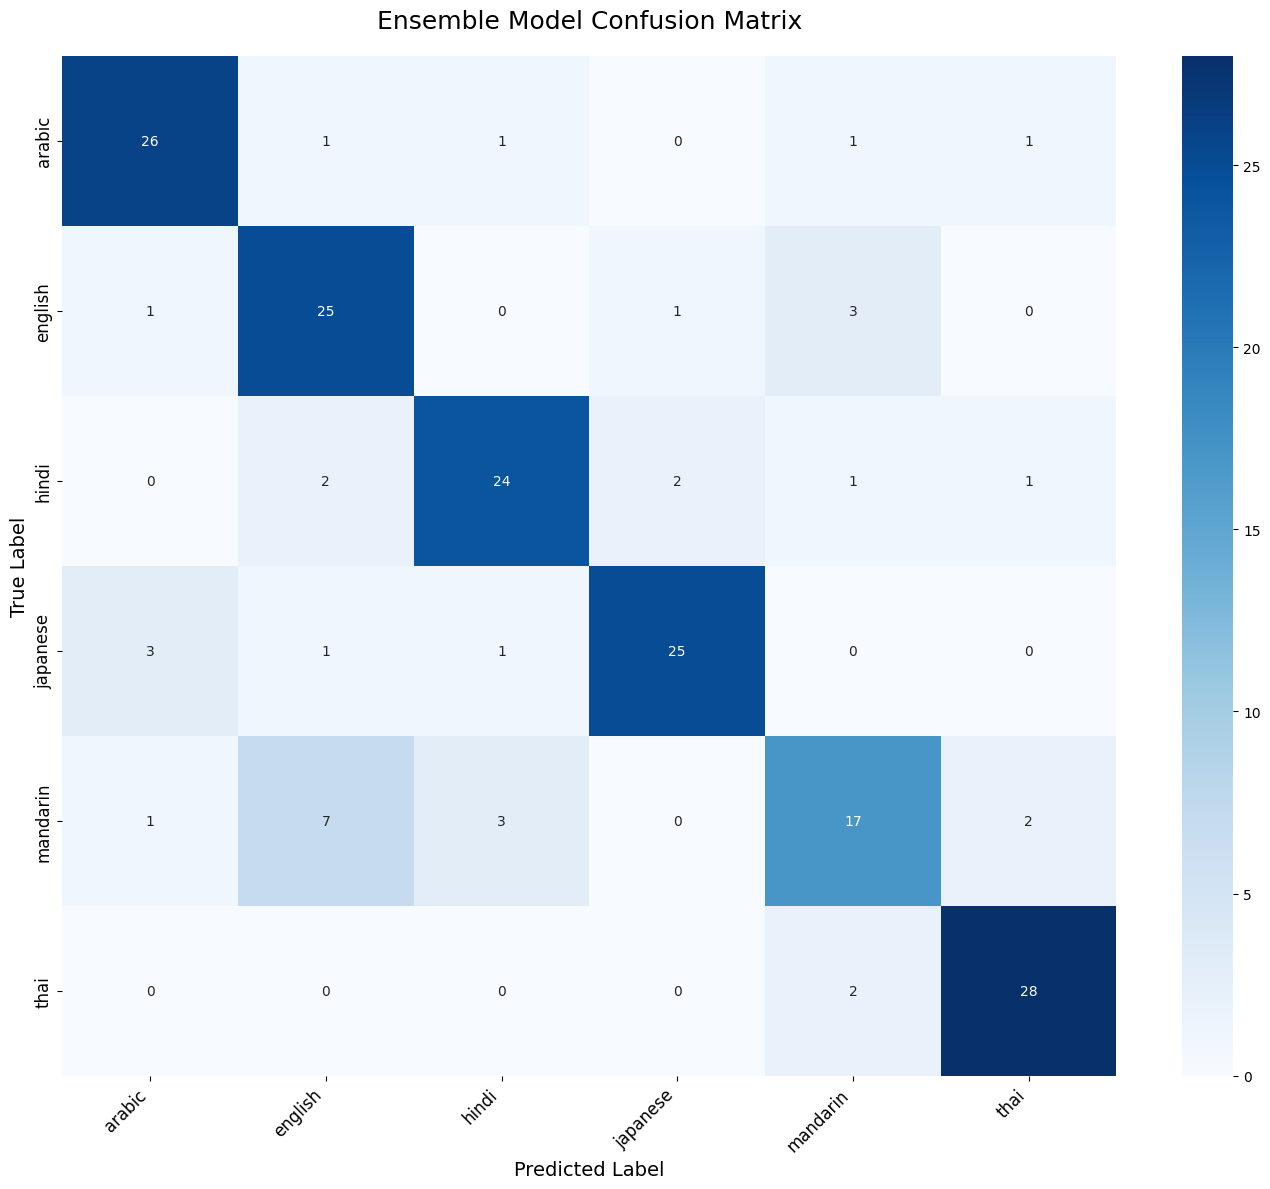

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


NameError: name 'bars' is not defined

<Figure size 1200x800 with 0 Axes>

In [10]:
def main():
    # กำหนดค่าเริ่มต้น
    data_dir = r"D:\Y2.2\Speech_Accent_Detection\app\main_datadset"  # แก้ไขเป็นโฟลเดอร์ที่เก็บข้อมูลเสียง
    model_dir = "Model"
    
    # สร้างโฟลเดอร์สำหรับเก็บโมเดล
    os.makedirs(model_dir, exist_ok=True)
    
    # เลือกภาษาที่มีลักษณะเสียงแตกต่างกันชัดเจน
    selected_accents = ['thai', 'english', 'mandarin', 'arabic', 'japanese', 'hindi']
    
    # โหลดข้อมูลและเตรียมพร้อม
    result = load_and_preprocess_data(data_dir, selected_accents)
    
    if result[0] is None:
        print("ไม่สามารถดำเนินการต่อได้เนื่องจากไม่มีข้อมูล")
        return
    
    X, y, label_encoder, file_paths = result
    
    # ดำเนินการต่อไป...  
    # บันทึก label encoder ไว้ใช้ในอนาคต
    joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))
    
    # แบ่งข้อมูลเป็นชุดฝึกสอน, ชุดตรวจสอบ, และชุดทดสอบ
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1))
    
    print(f"ขนาดข้อมูลฝึกสอน: {X_train.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลตรวจสอบ: {X_val.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลทดสอบ: {X_test.shape[0]} ตัวอย่าง")
    
    # ฝึกสอนโมเดล CNN + RNN hybrid
    print("\n===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====")
    cnn_rnn_model = build_cnn_rnn_model(X_train.shape[1:], y_train.shape[1])
    cnn_rnn_history, trained_cnn_rnn_model = train_model_with_advanced_techniques(
        cnn_rnn_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
    )
    
    # ประเมินผลโมเดล CNN + RNN hybrid
    print("\n===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====")
    class_names = label_encoder.classes_
    evaluate_and_visualize(trained_cnn_rnn_model, X_test, y_test, class_names, label_encoder, cnn_rnn_history)
    
    # ฝึกสอนโมเดล ResNet
    print("\n===== กำลังฝึกสอนโมเดล ResNet =====")
    resnet_model = build_resnet_model(X_train.shape[1:], y_train.shape[1])
    resnet_history, trained_resnet_model = train_model_with_advanced_techniques(
        resnet_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_resnet_model.h5')
    )
    
    # ประเมินผลโมเดล ResNet
    print("\n===== ผลลัพธ์การทดสอบโมเดล ResNet =====")
    evaluate_and_visualize(trained_resnet_model, X_test, y_test, class_names, label_encoder, resnet_history)
    
    # สร้างและฝึกสอนโมเดล Ensemble
    print("\n===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====")
    ensemble_models = build_ensemble_models(X_train, y_train, num_models=2)
    trained_ensemble, ensemble_histories = train_ensemble_models(
        ensemble_models, X_train, y_train, X_val, y_val, 
        base_model_path=os.path.join(model_dir, 'accent_ensemble_model')
    )
    
    # ประเมินผลโมเดล Ensemble
    print("\n===== ผลลัพธ์การทดสอบโมเดล Ensemble =====")
    # ทำนายด้วย ensemble
    ensemble_preds = ensemble_predict(trained_ensemble, X_test)
    y_pred = np.argmax(ensemble_preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล Ensemble =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix สำหรับ Ensemble
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Ensemble Model Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
    
    # เปรียบเทียบความแม่นยำของโมเดลทั้งหมด
    plt.figure(figsize=(12, 8))

    # ทำนายด้วยแต่ละโมเดล
    cnn_rnn_preds = trained_cnn_rnn_model.predict(X_test)
    cnn_rnn_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(cnn_rnn_preds, axis=1))

    resnet_preds = trained_resnet_model.predict(X_test)
    resnet_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(resnet_preds, axis=1))

    # ข้อมูลสำหรับกราฟแท่ง
    models = ['CNN+RNN', 'ResNet', 'Ensemble']
    accuracies = [
        cnn_rnn_acc * 100, 
        resnet_acc * 100,
        accuracy * 100
    ]

    # เพิ่มค่าบนแท่ง
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12
        )
    
    plt.title('Model Comparison: Accuracy', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()
    
    print("\nการฝึกสอนและทดสอบโมเดลเสร็จสิ้น")
    def preprocess_audio_file(audio_path, model_dir="Model"):
        try:
            # สกัดคุณลักษณะจากไฟล์เสียง
            features = extract_advanced_features(audio_path)
            if features is None:
                return None
            
            # แปลงเป็น numpy array และเพิ่มมิติแบตช์
            features = np.expand_dims(features, axis=0)
            
            return features
        except Exception as e:
            print(f"เกิดข้อผิดพลาดในการประมวลผลไฟล์เสียง: {str(e)}")
            return None

def predict_accent(audio_path, model_dir="Model"):
    """
    ทำนายสำเนียงจากไฟล์เสียง
    """
    try:
        # โหลด label encoder
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        
        # โหลดโมเดล ensemble
        models = []
        for i in range(3):
            model_path = os.path.join(model_dir, f'accent_ensemble_model_{i+1}.h5')
            if os.path.exists(model_path):
                models.append(load_model(model_path))
            else:
                print(f"ไม่พบไฟล์โมเดล {model_path}")
        
        if len(models) == 0:
            # ถ้าไม่มีโมเดล ensemble ให้ใช้โมเดล CNN+RNN แทน
            model_path = os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
            if os.path.exists(model_path):
                model = load_model(model_path)
                models = [model]
            else:
                raise FileNotFoundError("ไม่พบไฟล์โมเดล")
        
        # ประมวลผลไฟล์เสียง
        features = preprocess_audio_file(audio_path, model_dir)
        if features is None:
            return "ไม่สามารถประมวลผลไฟล์เสียงได้"
        
        # ทำนาย
        if len(models) > 1:
            # ใช้ ensemble
            predictions = []
            for model in models:
                pred = model.predict(features)
                predictions.append(pred)
            pred_probs = np.mean(predictions, axis=0)[0]
        else:
            # ใช้โมเดลเดียว
            pred_probs = models[0].predict(features)[0]
        
        # จัดอันดับผลการทำนาย
        top_indices = np.argsort(pred_probs)[::-1]
        
        # แสดงผลลัพธ์
        results = []
        for i, idx in enumerate(top_indices[:3]):  # แสดง 3 อันดับแรก
            accent = label_encoder.classes_[idx]
            confidence = pred_probs[idx] * 100
            results.append((accent, confidence))
        
        return results
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการทำนาย: {str(e)}")
        return "เกิดข้อผิดพลาดในการทำนาย"
if __name__ == "__main__":
    main()